- Pytorch 1.4.0
- model EfficientNet-B3
- image size 128x128

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import warnings
warnings.filterwarnings("ignore")

from crop_resize import read_parquets

In [2]:
model_name = 'efficientnet-b3'
#pretrained_model_name = './20200308_fold0_no_aug_0-1/efficientnet-b3_29_cpu.pth'
#pretrained_model_name = './20200309_rotate/efficientnet-b3_19_cpu.pth'
#pretrained_model_name = './20200310_mixup/efficientnet-b3_19_cpu.pth'
#pretrained_model_name = './20200311_cutmix/efficientnet-b3_19_cpu.pth'
pretrained_model_name = './20200312_mixup_cutmix/efficientnet-b3_19_cpu.pth'
height = 137
width = 236
image_size = 128
batch_size = 1
device = torch.device("cpu")
print(device)

in_dir = Path('../input/bengaliai-cv19')
out_dir = Path('')

cpu


<a id="images"></a>
# Images

In [3]:
filenames = [in_dir/f'test_image_data_{i}.parquet' for i in range(4)]
images = read_parquets(filenames, width, height, image_size)
print(images.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3007.39it/s]

(12, 1, 128, 128)


<a id="dataset"></a>
# Dataset

In [4]:
from torch.utils.data import Dataset

class GraphemeDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.train = labels is not None
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = image / image.max()
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = self.labels[idx]
            return image, label[0], label[1], label[2]
        else:
            return image

In [5]:
test_dataset = GraphemeDataset(images)
print(len(test_dataset))

12


<a id="visualize"></a>
# Visualize

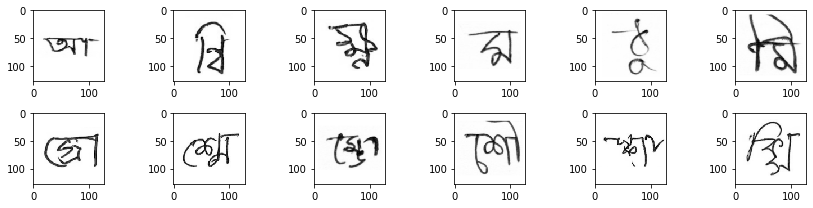

In [6]:
nrow, ncol = 2, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image = test_dataset[i][0]
    ax.imshow(image, cmap='Greys')
plt.tight_layout()
plt.show()

<a id="dataloader"></a>
# DataLoader

In [7]:
from torch.utils.data import DataLoader

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print('train loader length', len(test_loader))

train loader length 12


<a id="model"></a> 
# Model

In [8]:
from my_efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained(model_name, in_channels=1).to(device)
model.load_state_dict(torch.load(pretrained_model_name))

Loaded pretrained weights for efficientnet-b3


<All keys matched successfully>

<a id="inference"></a> 
# Inference

In [9]:
row_id = []
target = []

model.eval()

with torch.no_grad():
    for idx, inputs in tqdm(enumerate(test_loader), total=len(test_loader)):
        inputs = inputs.float()
        outputs1, outputs2, outputs3 = model(inputs)
        p1 = outputs1.argmax(-1).view(-1).cpu()
        p2 = outputs2.argmax(-1).view(-1).cpu()
        p3 = outputs3.argmax(-1).view(-1).cpu()
        row_id += [f'Test_{idx}_grapheme_root', f'Test_{idx}_vowel_diacritic', f'Test_{idx}_consonant_diacritic']
        target += [p1.item(), p2.item(), p3.item()]

sub_df = pd.DataFrame({'row_id': row_id, 'target': target})
sub_df.to_csv(out_dir/'submission.csv', index=False)
sub_df

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
5,Test_1_consonant_diacritic,0
6,Test_2_grapheme_root,19
7,Test_2_vowel_diacritic,0
8,Test_2_consonant_diacritic,0
9,Test_3_grapheme_root,115


In [10]:
#torch.save(model.state_dict(), './20200312_mixup_cutmix/efficientnet-b3_19_cpu.pth')